# sofa

The purpose of this notebook is to try out some initial explorations
of the moving sofa problem.

## Imports

In [396]:
%matplotlib inline

import json
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

In [4]:
from IPython.display import display

## Constants

In [34]:
pi = math.pi

## Learn how to make and show a simple image

In [5]:
np_arr = np.zeros((200, 200, 3))

In [6]:
im = Image.fromarray(np_arr.astype(np.uint8))

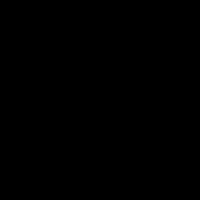

In [7]:
im

In [8]:
# Let's make a 20-pixel-wide hallway corner.

HALLWAY_WIDTH = 20

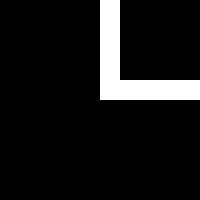

In [10]:
# Let's make a 20-pixel-wide hallway corner.

x_lo = 100
x_hi = x_lo + HALLWAY_WIDTH

y_lo = 100 - HALLWAY_WIDTH
y_hi = 100

np_arr = np.zeros((200, 200, 3))
np_arr[y_lo:y_hi, x_lo:] = 255
np_arr[:y_hi, x_lo:x_hi] = 255
im = Image.fromarray(np_arr.astype(np.uint8))
im

# Learn how to rotate an image

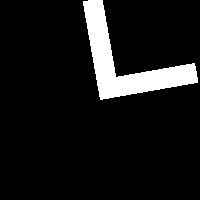

In [11]:
im.rotate(10)

# Learn how to take the intersection of two images

In [12]:
np_arr = np.asarray(im).astype(np.float32) / 255
np.min(np_arr), np.max(np_arr)

(0.0, 1.0)

In [13]:
def to_array(im):
    return np.asarray(im).astype(np.float32) / 255

In [14]:
def to_im(arr):
    return Image.fromarray((arr * 255).astype(np.uint8))

In [15]:
def intersect_images(im1, im2):
    arr1 = to_array(im1)
    arr2 = to_array(im2)
    return to_im(arr1 * arr2)

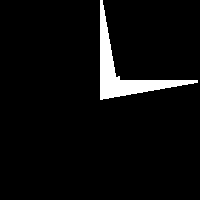

In [16]:
intersect_images(im, im.rotate(10))

## Be able to find the intersection of an arbitrary rotate around an arbitrary point

In [17]:
im.size

(200, 200)

In [18]:
def find_next_intersection(pos, isect, angle, center):
    ''' This accepts the following parameters:
        * pos    = The hallway in its current position; an Image object.
        * isect  = The intersection of all previous steps; an Image object.
        * angle  = The angle, in degrees (with apologies), of the rotation.
        * center = The center of rotation. (0, 0) is the original outside corner.
                   (1, 1) is the original inside corner.
    '''
    
    # Convert the center to image-based coordinates.
    w, h = im.size
    center = (
        w // 2 - center[1] * HALLWAY_WIDTH,
        h // 2 + center[0] * HALLWAY_WIDTH
    )
    
    # XXX This whole function while I write it.
    
    print()
    print('pos:')
    display(pos)
    
    print()
    print('isect:')
    display(isect)
    
    num_steps = 3
    
    for i in range(num_steps):
        pos = pos.rotate(angle / num_steps, center=center)
        print('\npos:'); display(pos)
        isect = intersect_images(isect, pos)
        print('\nisect:'); display(isect)
    
    


pos:


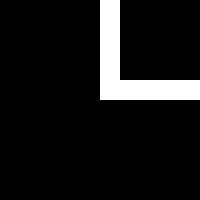


isect:


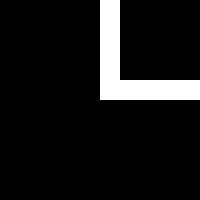


pos:


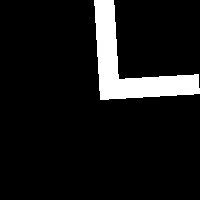


isect:


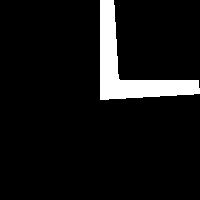


pos:


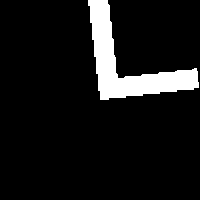


isect:


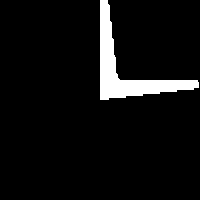


pos:


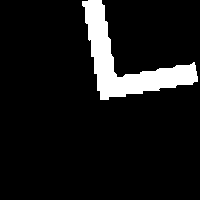


isect:


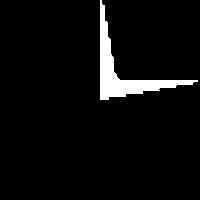

In [19]:
find_next_intersection(im, im, 10, (0, 0))

### Notes

Ok, there's a problem with this approach. What's happening is that
I'm losing image integrety as I iteratively rotate it.

As a digression, it might be interesting to study the patterns that
naturally arise by doing this. However, I think a better approach
here is to keep track of a single cumulative transformation matrix,
and to always use that to generate a current-position hallway
image each time we take the intersection with it.

## Be able to dynamically generate a hallway image from a transformation matrix

The hallway will be a polygon between these points, going counterclockwise
in the Cartesian plane:

    (0, 0) -- (A, 0) -- (A, 1) -- (1, 1) -- (1, A) -- (0, A) -- [close]

Here, `A` is some large enough value that I think is mostly unimportant.
I'm guessing a value as low as 3 would suffice. (If we find all optimal shapes,
then we can say with certainty exactly how large `A` really needs to be.)

I'll think of each of those 2d points $p=(x, y)$ as a column vector
$\begin{pmatrix}x \\ y \\ 1 \end{pmatrix}$, and then we can use a transformation matrix
$T$ by mapping $p$ to $Tp$.

A rotation by $\theta$ radians around the origin is given by

$$ T = \begin{pmatrix} \cos\theta & -\sin\theta & 0 \\
\sin\theta & \cos\theta & 0 \\
0 & 0 & 1 \\
\end{pmatrix}. $$

A rotation around $(x, y)$ can be achieved by (i) translating
$(x, y)$ to the origin; (ii) rotating around the origin, and then (iii)
translating the origin back to $(x, y)$.

In [20]:
def to_col(p):
    return np.array(list(p) + [1]).reshape(3, 1)

In [21]:
to_col([10, 20])

array([[10],
       [20],
       [ 1]])

In [22]:
# Be able to draw a polygon in an image.

np_arr = np.zeros((200, 200, 3))
im = Image.fromarray(np_arr.astype(np.uint8))
draw = ImageDraw.Draw(im)
draw.polygon([(10, 10), (20, 100), (100, 40)], fill='white')

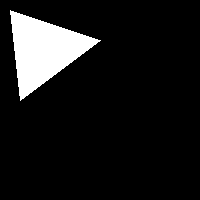

In [23]:
im

In [24]:
# Define transformation primitives.
# I'll start these all with `tr_` for 'transformation'.

# Rotation.
def tr_rot(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0            , 0             , 1]
    ])

# Translation.
def tr_add(x, y):
    return np.array([
        [1, 0, x],
        [0, 1, y],
        [0, 0, 1]
    ])

# Scale.
def tr_scl(s):
    return np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])

In [64]:
PIXEL_SIZE = 200

def make_transformed_hallway(T, far=30):
    ''' This returns the image of the hallway once transformation T is applied. '''
    
    # Use eps to avoid integer alignment so that area estimates are more accurate.
    eps = 0.0001
    far = far - eps
    one = 1   - eps
    
    pts = list(map(to_col, [
        [  0,   0],
        [far,   0],
        [far, one],
        [one, one],
        [one, far],
        [  0, far]
    ]))
    
    # After applying the mathematical transformation T, we'll also
    # convert the points from Cartesian coordinates to pixel coords.
    
    mid = (PIXEL_SIZE - HALLWAY_WIDTH) // 2
    to_pixels = tr_add(mid, mid).dot(tr_scl(HALLWAY_WIDTH))
    T = to_pixels.dot(T)
    
    for i in range(len(pts)):
        pts[i] = tuple(T.dot(pts[i]).reshape(3)[:2])
        
    np_arr = np.zeros((200, 200, 3))
    im = Image.fromarray(np_arr.astype(np.uint8))
    draw = ImageDraw.Draw(im)
    draw.polygon(pts, fill='white')
    
    return im

In [65]:
def estimate_area(img):
    ''' This accepts an Image object and returns the estimated area that has nonzero pixels.
        This expects the pixels to be either black or white.
    '''
    arr = to_array(img)
    return np.sum(arr) / 3 / HALLWAY_WIDTH ** 2

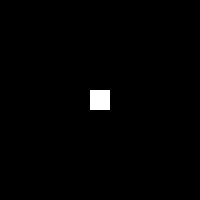

In [66]:
# Sanity check our area estimation.

A = 0.999

# Make a single white square in an image.
pts = list(map(to_col, [
    [0, 0],
    [A, 0],
    [A, A],
    [0, A]
]))

mid = (PIXEL_SIZE - HALLWAY_WIDTH) // 2
T   = tr_add(mid, mid).dot(tr_scl(HALLWAY_WIDTH))

for i in range(len(pts)):
    pts[i] = tuple(T.dot(pts[i]).reshape(3)[:2])

np_arr = np.zeros((200, 200, 3))
im = Image.fromarray(np_arr.astype(np.uint8))
draw = ImageDraw.Draw(im)
draw.polygon(pts, fill='white')

im

In [67]:
estimate_area(im)

1.0

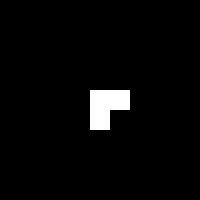

In [68]:
test_img = make_transformed_hallway(np.eye(3), far=2)
test_img

In [69]:
estimate_area(test_img)

3.0

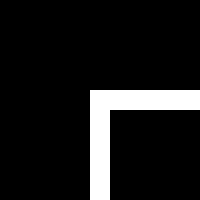

In [71]:
base_img = make_transformed_hallway(np.eye(3))
base_img

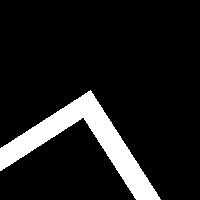

In [72]:
make_transformed_hallway(tr_rot(1))

In [73]:
# Test a rotation around (1, 1).

# "Spin", meaning a rotation around a given point.
def tr_spn(theta, x, y):
    return tr_add(x, y).dot(tr_rot(theta).dot(tr_add(-x, -y)))

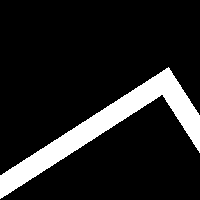

In [74]:
make_transformed_hallway(tr_spn(1, 3, 3))

## Be able to generate a new intersection from previous state

In [76]:
def find_next_intersection(T, isect, angle, center):
    ''' This accepts the following parameters:
        * T      = The current hallway transformation; a 3x3 matrix as an ndarray.
        * isect  = The intersection of all previous steps; an Image object.
        * angle  = The angle, in degrees (with apologies), of the rotation.
        * center = The center of rotation. (0, 0) is the original outside corner.
                   (1, 1) is the original inside corner.
    '''
    
    # XXX This whole function while I write it.
    
    print()
    print('pos:')
    pos = make_transformed_hallway(T)
    display(pos)
    
    print()
    print('isect:')
    display(isect)
    
    num_steps = 3
    
    for i in range(num_steps):
        U = tr_spn(angle * (i + 1) / num_steps, center[0], center[1]).dot(T)
        pos = make_transformed_hallway(U)
        print(f'\npos (step {i + 1} / {num_steps}):'); display(pos)
        isect = intersect_images(isect, pos)
        print('\nisect:'); display(isect)


pos:


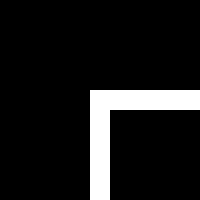


isect:


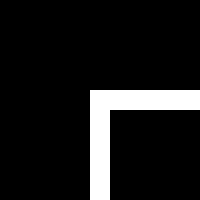


pos (step 1 / 3):


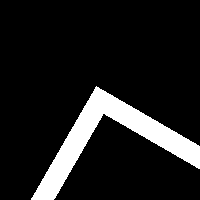


isect:


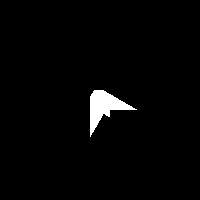


pos (step 2 / 3):


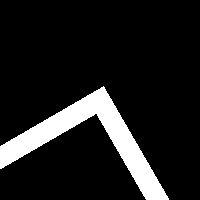


isect:


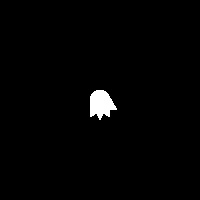


pos (step 3 / 3):


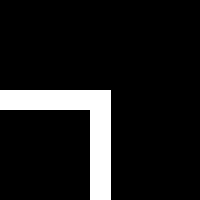


isect:


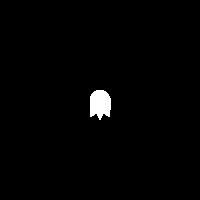

In [77]:
find_next_intersection(np.eye(3), base_img, pi / 2, (0.5, 0.5))

In [253]:
def find_next_intersection(T, isect, angle, center):
    ''' This accepts the following parameters:
        * T      = The current hallway transformation; a 3x3 matrix as an ndarray.
        * isect  = The intersection of all previous steps; an Image object.
        * angle  = The angle, in degrees (with apologies), of the rotation.
        * center = The center of rotation. (0, 0) is the original outside corner.
                   (1, 1) is the original inside corner.
    '''
    
    num_steps = 20
    
    for i in range(num_steps):
        U = tr_spn(angle * (i + 1) / num_steps, center[0], center[1]).dot(T)
        pos = make_transformed_hallway(U)
        isect = intersect_images(isect, pos)
    
    return U, isect

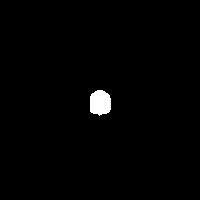

In [254]:
_, isect = find_next_intersection(np.eye(3), base_img, pi / 2, (0.5, 0.5))
isect

In [255]:
estimate_area(isect)

1.125

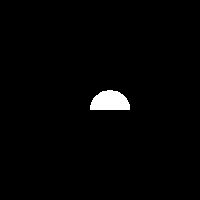

In [256]:
_, isect = find_next_intersection(np.eye(3), base_img, pi / 2, (1, 1))
isect

In [257]:
estimate_area(isect)

1.585

In [258]:
pi / 2

1.5707963267948966

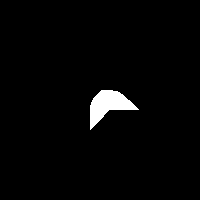

In [259]:
T, img = find_next_intersection(np.eye(3), base_img, pi / 4, (1, 1))
img

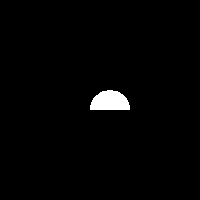

In [260]:
_, img = find_next_intersection(T, img, pi / 4, (1, 1))
img

## Write up a quick version of the evolutionary algorithm

In [261]:
def pass_(vec):
    pass

In [324]:
def evolve(
    population     = [],
    score_fn       = pass_,
    mutate_fn      = pass_,
    cross_fn       = pass_,
    max_population = 50,
    iters          = 10
):
    
    for i in range(iters):
        
        #print(f'Starting iteration {i + 1}.')

        # Sort the critters by their scores.
        # The best ones will be first.
        population = sorted(population, key=score_fn, reverse=True)
        #print(population)
        
        best = score_fn(population[0])
        print(f'\rIteration {i + 1}; best score so far is {best}         ', end='', flush=True)

        # Prune the population as needed.
        population = population[:max_population]
        n = len(population)

        # Assign a weight to each critter.
        # The + 2 here is a bit arbitrary and controls how strongly
        # the front of the list is preferred.
        weights = 1 / (np.arange(n) + 2)

        # Randomly mutate some of them.
        k = max(int(n * 0.3), 3)
        to_mutate = random.choices(population, weights, k=k)
        mutants = [mutate_fn(critter) for critter in to_mutate]

        # Randomly cross some pairs.
        kids = []
        if n > 1:
            k = max(int(n * 0.2), 3)
            nlist = list(range(n))
            for _ in range(k):
                pair = (0, 0)
                while pair[0] == pair[1]:
                    pair = random.choices(nlist, weights, k=2)
                kids.append(cross_fn(population[pair[0]], population[pair[1]]))

        population += mutants
        population += kids
    
    print()
        
    population = sorted(population, key=score_fn, reverse=True)
    return population

In [325]:
# Sanity check this function on trying to match a certain function.

xx = np.linspace(0, 1, 10)

In [326]:
len(xx), xx.shape, xx

(10,
 (10,),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]))

In [327]:
xx = xx - 2 * xx ** 2 + 1 * xx ** 3
xx

array([0.        , 0.0877915 , 0.13443073, 0.14814815, 0.13717421,
       0.10973937, 0.07407407, 0.03840878, 0.01097394, 0.        ])

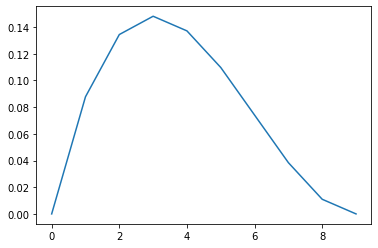

In [328]:
plt.plot(xx);

In [329]:
pop = [np.zeros((10,))]

In [330]:
def score1(v):
    return -np.sum((v - xx) ** 2)

In [331]:
score1(pop[0])

-0.08566896419357932

In [332]:
np.random.randn(10) * 0.01

array([-0.00226479,  0.00799512,  0.00083677, -0.00501661, -0.00458767,
       -0.00244192, -0.01220662, -0.00795831,  0.00094409, -0.02943586])

In [333]:
def mutate1(v):
    return v + np.random.randn(10) * 0.01

In [334]:
def cross1(v1, v2):
    return (v1 + v2) / 2

In [335]:
v = evolve(pop, score1, mutate1, cross1, iters=100)[0]

Iteration 100; best score so far is -0.00011478307803431062         


In [336]:
v

array([0.00357348, 0.08515634, 0.13578638, 0.14517708, 0.13508538,
       0.10605337, 0.08175615, 0.03999444, 0.00915681, 0.00127431])

In [337]:
xx

array([0.        , 0.0877915 , 0.13443073, 0.14814815, 0.13717421,
       0.10973937, 0.07407407, 0.03840878, 0.01097394, 0.        ])

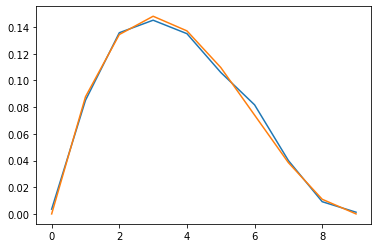

In [338]:
plt.plot(v)
plt.plot(xx);

In [339]:
# Sweet.

## See if we can apply the evolutionary algorithm to the sofa problem

To start with, I'll just have two rotations. A single critter will be
`[theta1, x1, y1, ignored, x2, y2]`; where I replace `ignored` by
`pi / 2 - theta1` when scoring it.

In [342]:
# The initial critter.
pop = [
    [0.1, 0, 0, 0, 0.5, 0.5]
]

In [343]:
def get_img_for_path(path):
    T, img = find_next_intersection(np.eye(3), base_img, path[0], path[1:3])
    angle_sum = path[0]
    for i in range(3, len(path), 3):
        angle = path[i]
        if i == len(path) - 3:
            angle = pi / 2 - angle_sum
        angle_sum += angle
        T, img = find_next_intersection(T, img, angle, path[i+1:i+3])
    return img

In [344]:
def score2(c):
    return estimate_area(get_img_for_path(c))

In [345]:
score2(pop[0])

1.035

In [346]:
[1, 2, 3] + np.random.randn(3)

array([0.56177127, 2.46875588, 3.27978706])

In [347]:
def mutate2(c):
    c = list(c + np.random.randn(6) * 0.02)
    c[0] = min(max(c[0], 0), pi / 2)
    return c

In [348]:
mutate2(pop[0])

[0.10470093746421774,
 -0.04874824113264951,
 -0.019357729641259796,
 0.0018176837675407968,
 0.495127132180924,
 0.47255463148111176]

In [349]:
def cross2(c1, c2):
    return list((np.array(c1) + np.array(c2)) / 2)

In [350]:
cross2(pop[0], pop[0])

[0.1, 0.0, 0.0, 0.0, 0.5, 0.5]

In [351]:
pop = evolve(pop, score2, mutate2, cross2, iters=10)

Iteration 10; best score so far is 1.1525         


In [352]:
pop[0]

[0.09237219737526936,
 0.0709664926581208,
 0.03087857741316833,
 -0.028047965387915333,
 0.5265616174194809,
 0.6348705144979256]

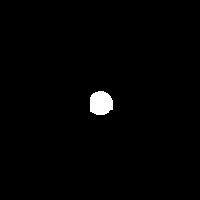

In [353]:
get_img_for_path(pop[0])

In [354]:
pop = evolve(pop, score2, mutate2, cross2, iters=20)

Iteration 20; best score so far is 1.375          


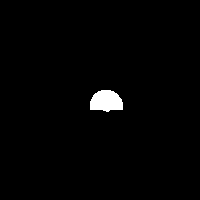

In [355]:
get_img_for_path(pop[0])

## Try for a more complicated path

In [357]:
# The initial critter.
pop = [
    np.random.randn(12) * .3
]
pop

[array([ 0.57478431,  0.42483184, -0.11572813,  0.43681772, -0.63773308,
        -0.36831624, -0.67617849, -0.11471574,  0.40370917, -0.56193975,
         0.04793081,  0.24112029])]

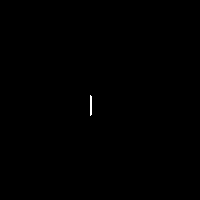

In [358]:
get_img_for_path(pop[0])

In [359]:
def score3(c):
    return estimate_area(get_img_for_path(c))

In [377]:
def mutate3(c):
    c = np.copy(c)
    c += np.random.randn(len(c)) * 0.02
    return c

In [361]:
def cross3(c1, c2):
    return (c1 + c2) / 2

In [363]:
pop = evolve(pop, score3, mutate3, cross3, iters=5)

Iteration 5; best score so far is 0.1025         


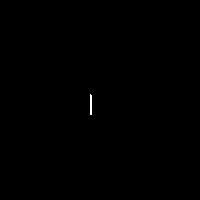

In [364]:
get_img_for_path(pop[0])

In [365]:
pop = evolve(pop, score3, mutate3, cross3, iters=20)

Iteration 20; best score so far is 0.8725         


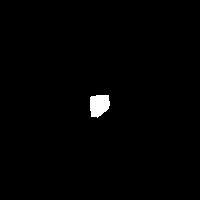

In [366]:
get_img_for_path(pop[0])

In [369]:
pop[0]

array([ 0.35446325,  0.57711843,  0.15669032,  0.09296224, -0.71008767,
       -0.19629068, -0.59900881, -0.02310537,  0.23921786, -0.4427228 ,
        0.24883295,  0.53891003])

In [370]:
def evolve(
    population     = [],
    score_fn       = pass_,
    mutate_fn      = pass_,
    cross_fn       = pass_,
    max_population = 50,
    iters          = 10
):
    
    best_scores = []
    
    for i in range(iters):
        
        #print(f'Starting iteration {i + 1}.')

        # Sort the critters by their scores.
        # The best ones will be first.
        population = sorted(population, key=score_fn, reverse=True)
        #print(population)
        
        best = score_fn(population[0])
        best_scores.append(best)
        
        print(f'\rIteration {i + 1}; best score so far is {best}         ', end='', flush=True)

        # Prune the population as needed.
        population = population[:max_population]
        n = len(population)

        # Assign a weight to each critter.
        # The + 2 here is a bit arbitrary and controls how strongly
        # the front of the list is preferred.
        weights = 1 / (np.arange(n) + 2)

        # Randomly mutate some of them.
        k = max(int(n * 0.3), 3)
        to_mutate = random.choices(population, weights, k=k)
        mutants = [mutate_fn(critter) for critter in to_mutate]

        # Randomly cross some pairs.
        kids = []
        if n > 1:
            k = max(int(n * 0.2), 3)
            nlist = list(range(n))
            for _ in range(k):
                pair = (0, 0)
                while pair[0] == pair[1]:
                    pair = random.choices(nlist, weights, k=2)
                kids.append(cross_fn(population[pair[0]], population[pair[1]]))

        population += mutants
        population += kids
    
    print()
        
    population = sorted(population, key=score_fn, reverse=True)
    return population, best_scores

In [373]:
score_history = []

Iteration 2; best score so far is 0.95         


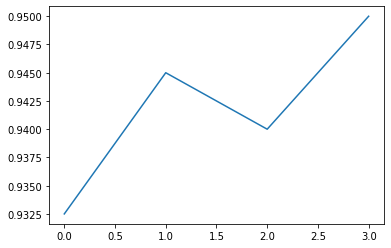

In [375]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=2)
score_history += scores
plt.plot(score_history);

Iteration 10; best score so far is 1.055         


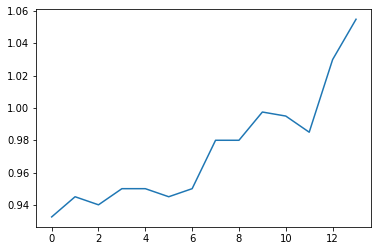

In [376]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=10)
score_history += scores
plt.plot(score_history);

In [378]:
# Scores going down is a bug. I think mutate3() was accidentally
# editing the input. Let's see if it's fixed now.

Iteration 10; best score so far is 1.1475         


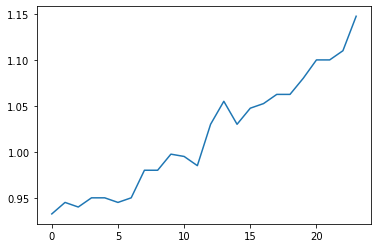

In [379]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=10)
score_history += scores
plt.plot(score_history);

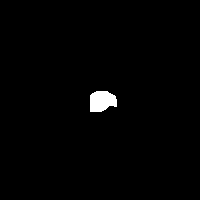

In [380]:
get_img_for_path(pop[0])

Iteration 20; best score so far is 1.3825         


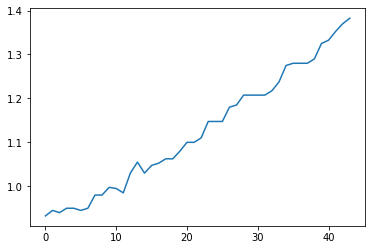

In [381]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);

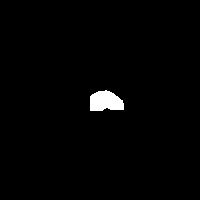

In [382]:
get_img_for_path(pop[0])

In [383]:
len(score_history)

44

Iteration 20; best score so far is 1.575          


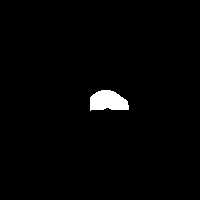

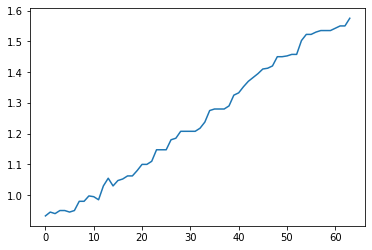

In [384]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [385]:
pi / 2

1.5707963267948966

Iteration 20; best score so far is 1.7025         


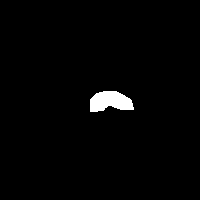

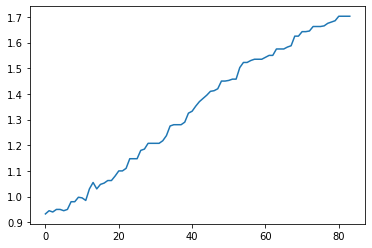

In [386]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 1.75          


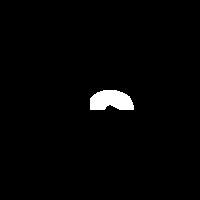

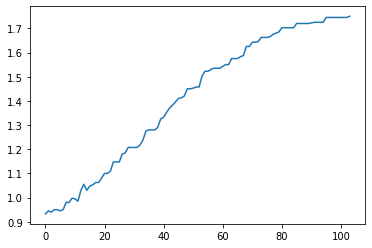

In [387]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 1.84           


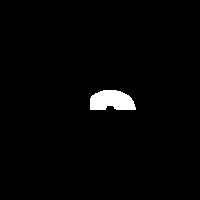

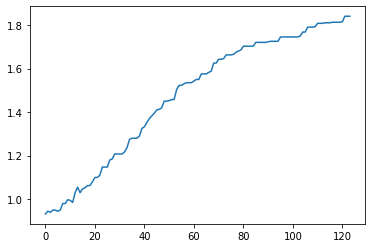

In [388]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 1.9675         


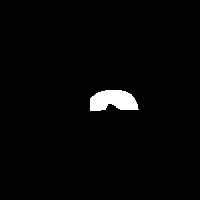

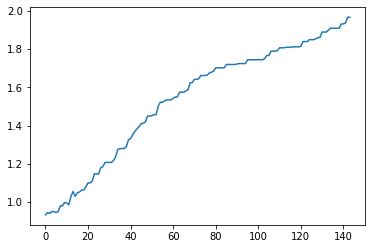

In [389]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 2.005          


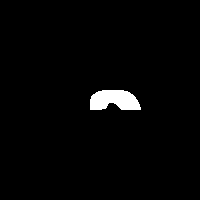

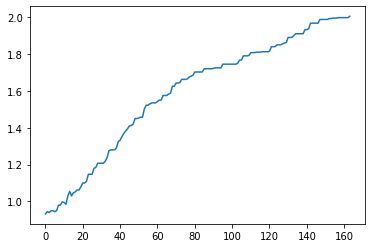

In [390]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [391]:
def find_next_intersection(T, isect, angle, center, num_steps=20):
    ''' This accepts the following parameters:
        * T      = The current hallway transformation; a 3x3 matrix as an ndarray.
        * isect  = The intersection of all previous steps; an Image object.
        * angle  = The angle, in degrees (with apologies), of the rotation.
        * center = The center of rotation. (0, 0) is the original outside corner.
                   (1, 1) is the original inside corner.
    '''
    for i in range(num_steps):
        U = tr_spn(angle * (i + 1) / num_steps, center[0], center[1]).dot(T)
        pos = make_transformed_hallway(U)
        isect = intersect_images(isect, pos)
    
    return U, isect

In [392]:
def get_img_for_path(path, num_steps_per_turn=20):
    T, img = find_next_intersection(np.eye(3), base_img, path[0], path[1:3], num_steps_per_turn)
    angle_sum = path[0]
    for i in range(3, len(path), 3):
        angle = path[i]
        if i == len(path) - 3:
            angle = pi / 2 - angle_sum
        angle_sum += angle
        T, img = find_next_intersection(T, img, angle, path[i+1:i+3], num_steps_per_turn)
    return img

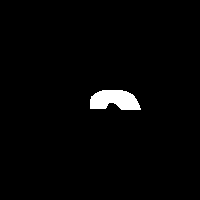

1.95

In [394]:
# Check if the ev. alg is gaming the system by taking advantage of our turn resolution.
img = get_img_for_path(pop[0], 100)
display(img)
estimate_area(img)

In [395]:
# I would say that is a tiny bit, yes.
# That's a little < 3% false area inflation.

In [397]:
# Save out the best path so far.

with open('three_turn_path.json', 'w') as f:
    json.dump(list(pop[0]), f)

In [407]:
three_spin_score_history = score_history

## See what we can do with more spins in the vector.

In [405]:
# The initial critter.
pop = [np.random.randn(24) * .01]

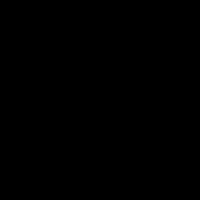

In [406]:
get_img_for_path(pop[0])

In [408]:
score_history = []

Iteration 2; best score so far is 0.0         


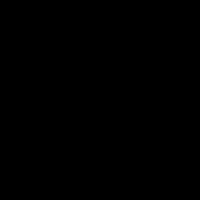

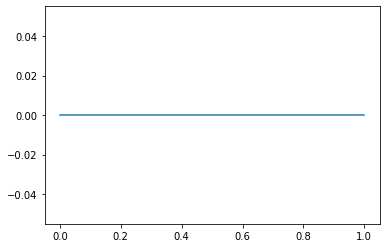

In [409]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=2)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 10; best score so far is 0.21          


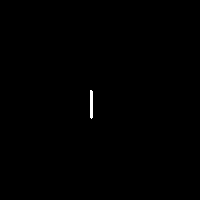

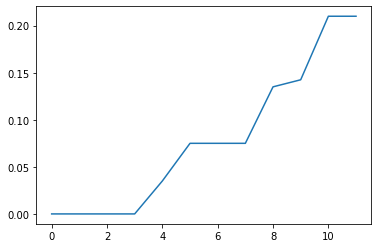

In [410]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=10)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 0.8075         


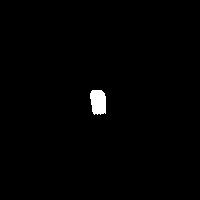

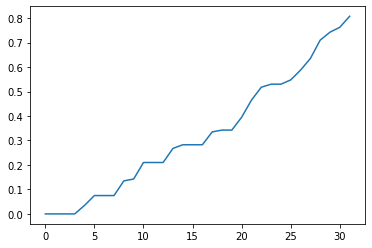

In [411]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 1.1125         


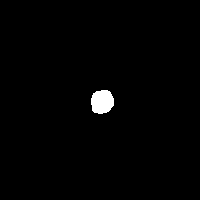

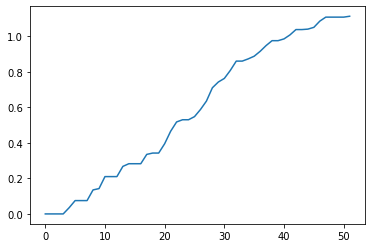

In [412]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [414]:
pop[0][::3]

array([-0.02916949,  0.02127907, -0.05763713, -0.06496669,  0.02405859,
       -0.06619599,  0.00881813,  0.09043008])

Iteration 30; best score so far is 1.3075         


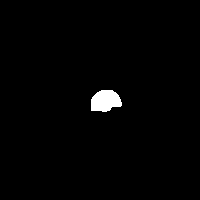

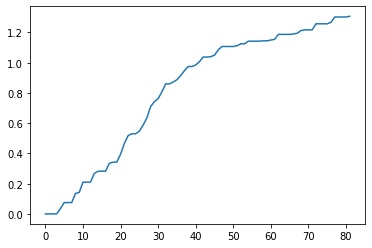

In [415]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=30)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 20; best score so far is 1.4            


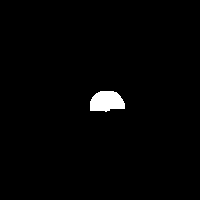

CPU times: user 2min 32s, sys: 3.18 s, total: 2min 36s
Wall time: 2min 38s


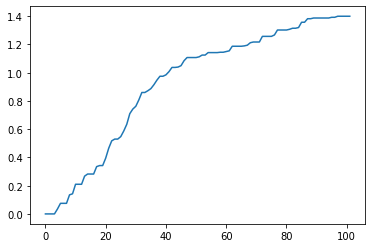

In [416]:
%%time
pop, scores = evolve(pop, score3, mutate3, cross3, iters=20)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 700; best score so far is 1.9675         


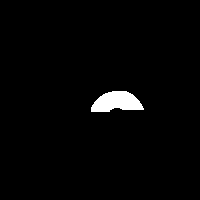

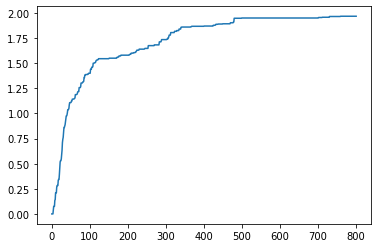

In [417]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=700)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [418]:
print(pop[0])

[ 3.13637121e-02  6.88160116e-02 -1.30841623e-01  4.21066104e-04
  1.66940519e-01 -1.04319624e-01 -1.90398830e-02 -3.29612386e-01
  2.12420678e-01  3.35480603e-03 -2.14440749e-01  1.61515300e-01
  1.14909222e-02 -2.13302016e-01 -1.61677315e-01  1.08009707e-02
 -5.57256472e-02  7.37715193e-02 -3.75263990e-02 -2.60789656e-01
 -5.01370067e-02  2.45787530e-01  1.33137913e+00  1.39138949e+00]


Iteration 700; best score so far is 1.9725         


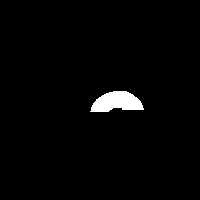

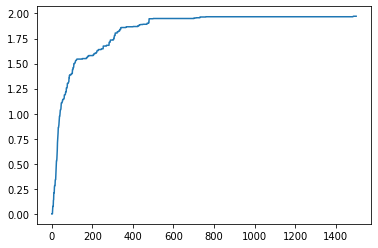

In [419]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=700)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 700; best score so far is 1.9725         


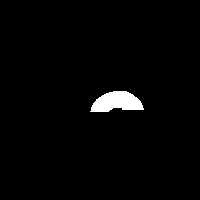

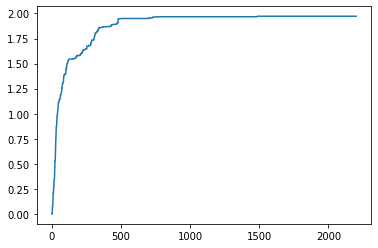

In [420]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=700)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [421]:
HALLWAY_WIDTH

20

In [440]:
PIXEL_SIZE = 300
HALLWAY_WIDTH = 40

In [441]:
def make_transformed_hallway(T, far=30):
    ''' This returns the image of the hallway once transformation T is applied. '''
    
    # Use eps to avoid integer alignment so that area estimates are more accurate.
    eps = 0.0001
    far = far - eps
    one = 1   - eps
    
    pts = list(map(to_col, [
        [  0,   0],
        [far,   0],
        [far, one],
        [one, one],
        [one, far],
        [  0, far]
    ]))
    
    # After applying the mathematical transformation T, we'll also
    # convert the points from Cartesian coordinates to pixel coords.
    
    mid = (PIXEL_SIZE - HALLWAY_WIDTH) // 2
    to_pixels = tr_add(mid, mid).dot(tr_scl(HALLWAY_WIDTH))
    T = to_pixels.dot(T)
    
    for i in range(len(pts)):
        pts[i] = tuple(T.dot(pts[i]).reshape(3)[:2])
        
    np_arr = np.zeros((PIXEL_SIZE, PIXEL_SIZE, 3))
    im = Image.fromarray(np_arr.astype(np.uint8))
    draw = ImageDraw.Draw(im)
    draw.polygon(pts, fill='white')
    
    return im

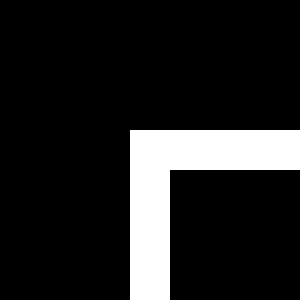

In [442]:
base_img = make_transformed_hallway(np.eye(3))
base_img

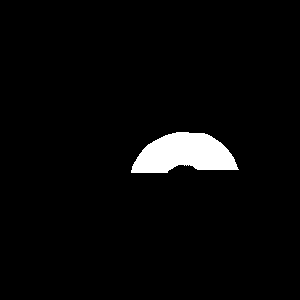

In [443]:
display(get_img_for_path(pop[0]))

In [444]:
estimate_area(base_img)

7.5

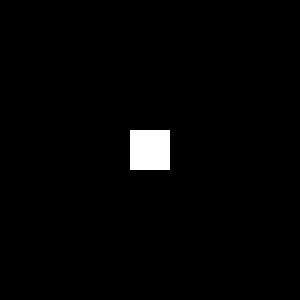

In [445]:
# Sanity check our area estimation.

A = 0.999

# Make a single white square in an image.
pts = list(map(to_col, [
    [0, 0],
    [A, 0],
    [A, A],
    [0, A]
]))

mid = (PIXEL_SIZE - HALLWAY_WIDTH) // 2
T   = tr_add(mid, mid).dot(tr_scl(HALLWAY_WIDTH))

for i in range(len(pts)):
    pts[i] = tuple(T.dot(pts[i]).reshape(3)[:2])

np_arr = np.zeros((PIXEL_SIZE, PIXEL_SIZE, 3))
im = Image.fromarray(np_arr.astype(np.uint8))
draw = ImageDraw.Draw(im)
draw.polygon(pts, fill='white')

im

In [446]:
estimate_area(im)

1.0

Iteration 10; best score so far is 1.92375         


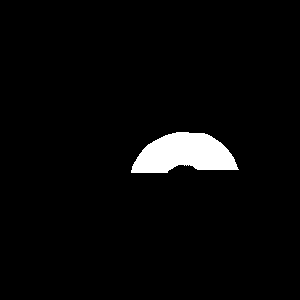

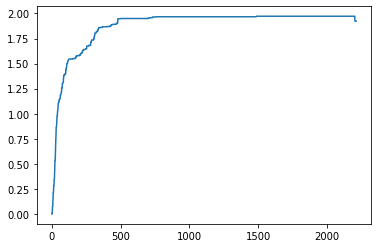

In [447]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=10)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [448]:
def mutate3(c):
    c = np.copy(c)
    c += np.random.randn(len(c)) * 0.005
    return c

Iteration 10; best score so far is 1.92375         


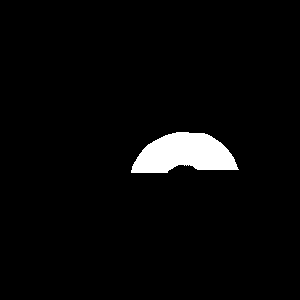

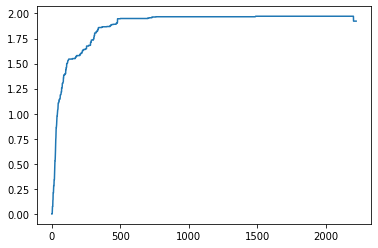

In [449]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=10)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [451]:
print(pop[0][::3])

[ 0.04314511  0.00432926 -0.03643599 -0.0013096   0.01399289  0.02746047
 -0.04634946  0.25515195]


In [454]:
np.sum(pop[0][:-3:3]) / (pi / 2)

0.003076578757695158

In [455]:
pop[0][-2:]

array([1.3424639 , 1.41399961])

In [462]:
estimate_area(get_img_for_path([0, 0, 0, 0, 1.39, 1.39]))

1.91125

## Try a different initial seed

In [473]:
# The initial critter.
pop = [np.abs(np.random.randn(24) * .5)]
pop[0]

array([0.12567623, 0.53522847, 0.59779294, 0.36488452, 0.18117236,
       0.83044196, 0.57275256, 0.00175972, 0.42744425, 0.47130477,
       0.08529207, 1.05107472, 0.79307364, 0.35323196, 0.30027036,
       0.10509905, 0.52769757, 0.16914866, 0.03002459, 0.16328333,
       0.6431454 , 0.00128365, 0.21061967, 0.64569643])

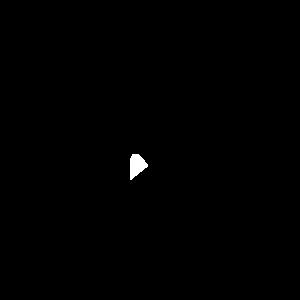

In [474]:
get_img_for_path(pop[0])

In [475]:
RATE = 1

In [476]:
def mutate3(c):
    global RATE
    c = np.copy(c)
    c += np.random.randn(len(c)) * RATE
    return c

In [477]:
score_history = []

Iteration 10; best score so far is 0.931875         


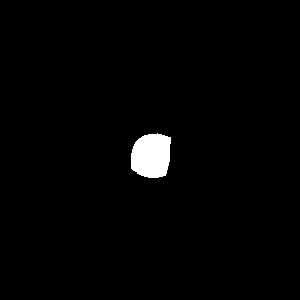

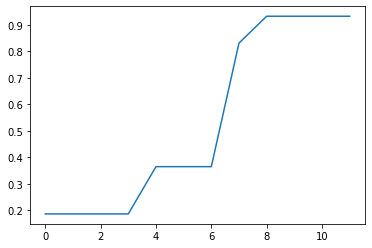

In [479]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=10)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [480]:
RATE = 0.5

Iteration 5; best score so far is 1.2325           


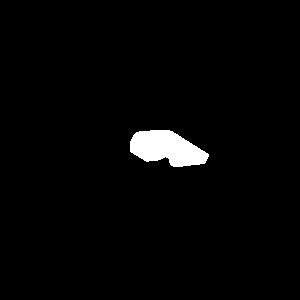

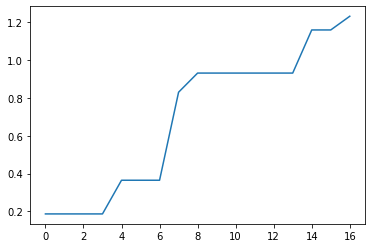

In [481]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=5)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [482]:
RATE = 0.4

Iteration 5; best score so far is 1.2525           


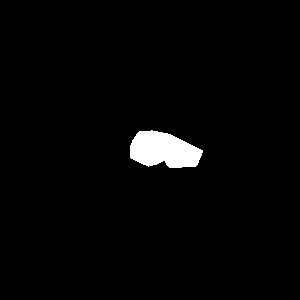

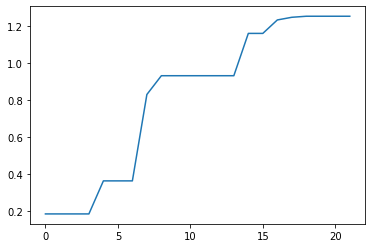

In [483]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=5)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [484]:
RATE = 0.1

Iteration 100; best score so far is 2.005           


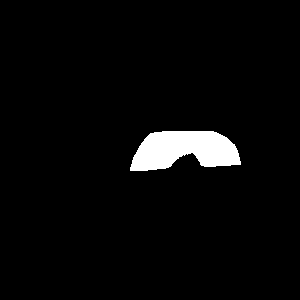

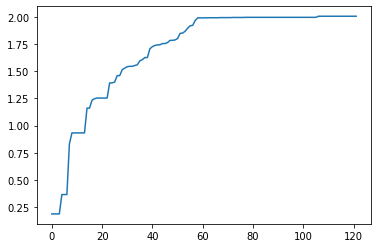

In [485]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=100)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

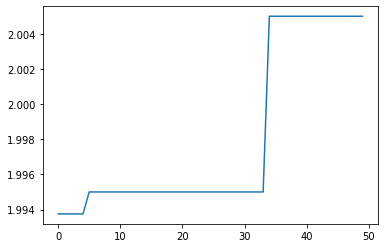

In [487]:
plt.plot(score_history[-50:]);

In [488]:
RATE = 0.05

Iteration 100; best score so far is 2.1425          


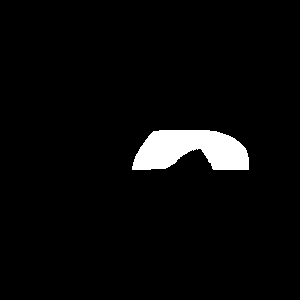

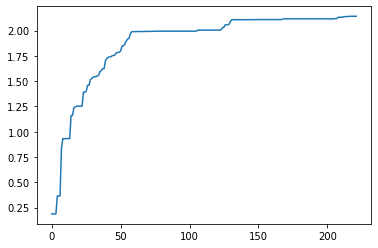

In [489]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=100)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

Iteration 200; best score so far is 2.143125         


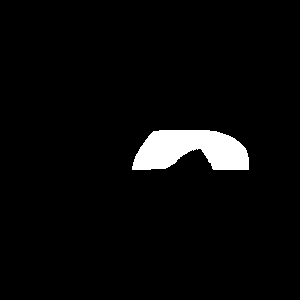

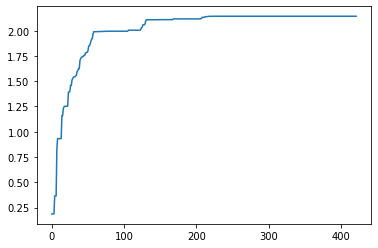

In [490]:
pop, scores = evolve(pop, score3, mutate3, cross3, iters=200)
score_history += scores
plt.plot(score_history);
display(get_img_for_path(pop[0]))

In [491]:
pop[0]

array([ 1.10026070e-03,  6.83911924e-01,  1.74552474e+00,  1.03048991e+00,
        1.85877556e+00,  1.39136646e+00,  4.21215610e-01,  9.65257854e-01,
        1.22002430e+00,  1.04717876e-02,  5.08274198e-01,  8.39421833e-01,
       -4.53411185e-02,  1.06226739e+00, -8.20366359e-02,  1.00589688e-01,
        1.00983588e+00,  5.48267223e-01,  2.68247403e-02,  2.09826777e-02,
        2.19799909e-01, -5.15516353e-01,  7.44928745e-01,  2.15703933e-01])

In [493]:
with open('8_turn_path.json', 'w') as f:
    json.dump(list(pop[0]), f)

In [494]:
!ls *.json

8_turn_path.json     three_turn_path.json
